# Super resolotion with GAN

In this notebook, we will scratch the surface with `GAN` and `UNET` by tackling the problem of **Super Resolution**.

In [1]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.callbacks import *
import fastai

## Preparing the pets data

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'     #path for high resolution images
path_lr = path/'crappy'     #crappified data

### Crappifying the data

Let's crappify our data to get some dirty images. The final goal is to restore the initial images at their best resolution

In [3]:
from crappify import *

now we will create our crappified version of each image. this process is time and ressource consuming. So do it just once and comment the following lines

In [9]:
#il = ImageList.from_folder(path_hr)
#parallel(crappifier(path_lr,path_hr), il.items)

We choose a target size and batch size accoring to hour graphical card ressources

In [4]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256


## Pretrained Generator

In [5]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
arch = models.resnet34

In [6]:
def get_data(bs,size):
    """
    Function to create a data bunch from the src according to the choosed bs and size
    """
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [7]:
data_gen = get_data(bs,size)

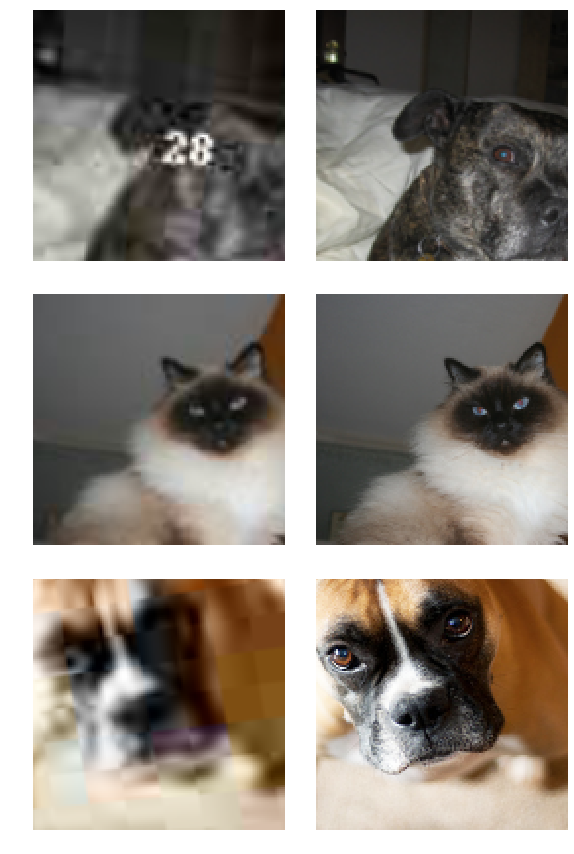

In [8]:
data_gen.show_batch(3)

### Generating learner

In [9]:
wd = 1e-3      #weight decay
y_range = (-3. ,3.)
loss_gen = MSELossFlat()          # loss function of the generator as Mean Square Error

In [10]:
# We should explain the (norm_type and sel_attention in future notebooks)
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)


Now let's create and train a generator, which from a crappy images $M_{low}$ tries to create a high resolution image $M_{high}$. As stated the generator loss is the simple `MSE`

In [11]:
learn_gen = create_gen_learner()

In [24]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch     train_loss  valid_loss  time    
0         0.063909    0.055554    01:30     
1         0.052246    0.048817    01:24     


In [26]:
learn_gen.unfreeze()

In [27]:
learn_gen.fit_one_cycle(1, slice(1e-6,1e-3))

epoch     train_loss  valid_loss  time    
0         0.050556    0.046401    01:29     


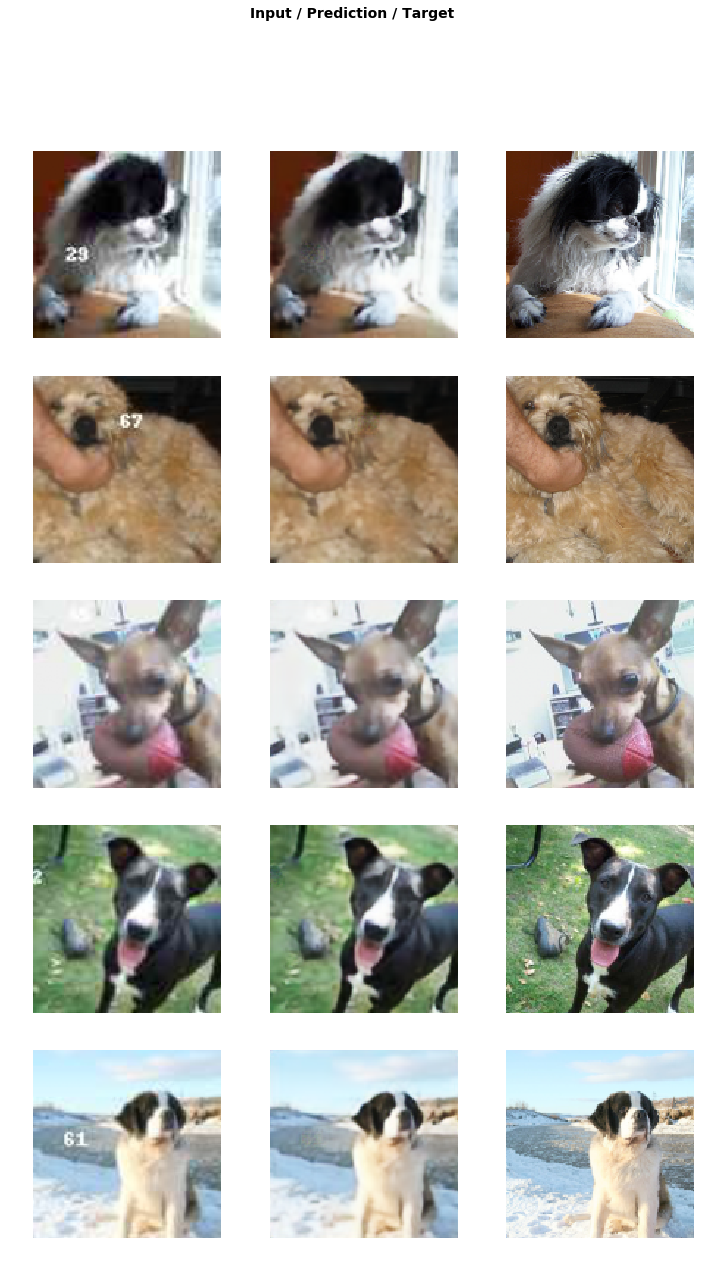

In [28]:
learn_gen.show_results()

Let's save the current state of our model

In [29]:
learn_gen.save('gen_pre2')

## Save the generated images

In [12]:
learn_gen.load('gen_pre2')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/anass/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/anass/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, 

In [13]:
#path of the generated images
name_gen = 'image_gen'
path_gen = path/name_gen

In [33]:
path_gen.mkdir(exist_ok=True) #creating the image ( the flag exist_ok )

Let's write a function to save the reconstructed images by a the generator. Those images will serve as input to our **critic** (Descriminator)

In [14]:
def save_preds(dl):   #dataloader
    i = 0
    #getting the names in the datalist
    names = dl.dataset.items
    
    #looping over the batches
    for b in dl:
        #computing the predictions
        preds = learn_gen.pred_batch(batch=b, reconstruct=True) #reconstruct to creat a real Image List
        #loop to save the images in preds
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [15]:
save_preds(data_gen.fix_dl)

Let's show a simple saved image from the generator

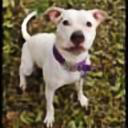

In [16]:
PIL.Image.open(path_gen.ls()[0])

## Training the descriminator

In [17]:
#collect garbage ( poor solution)
learn_gen=None
gc.collect()

7

Let's define a descriminator to differentiate images from crappy and not crappy

In [18]:
#Function to load the images since it will change after each iteration between the genrator and descriminator
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [19]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

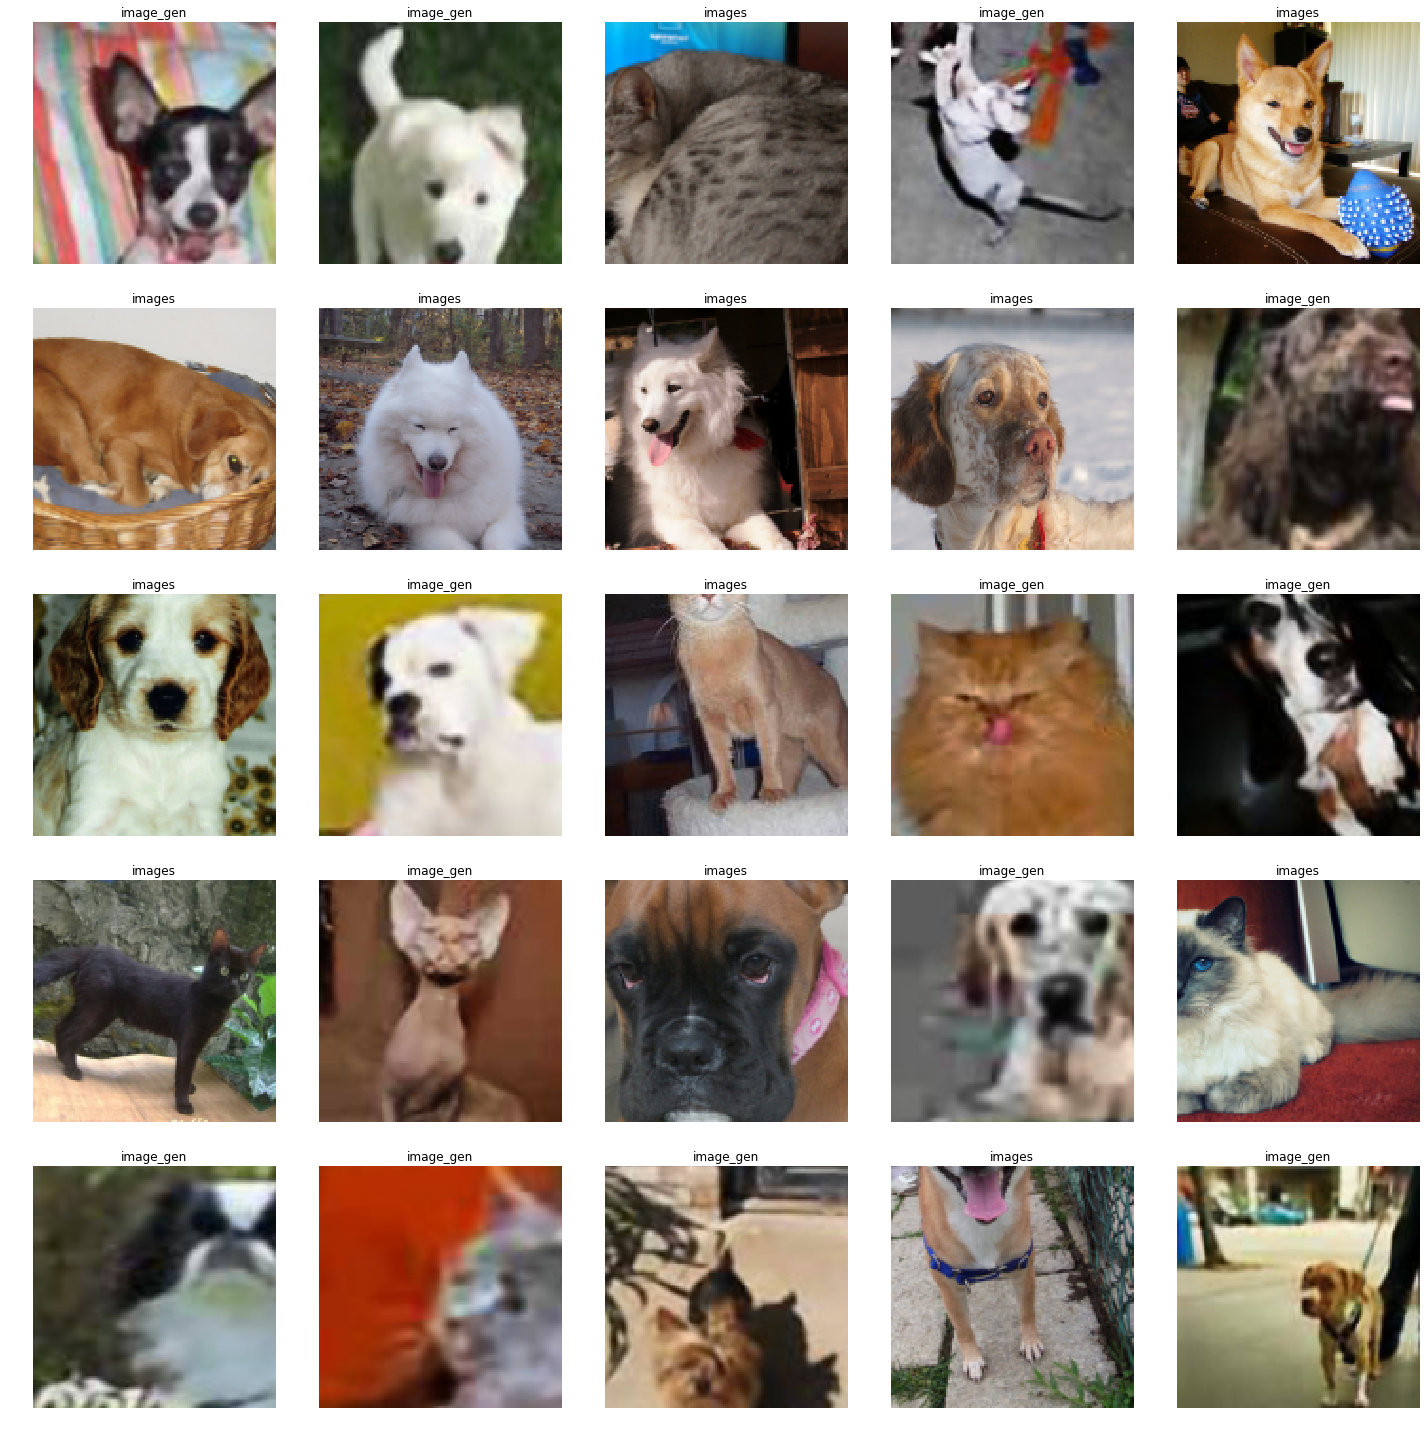

In [20]:
data_crit.show_batch()

Custom loss for the descriminator

In [21]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [22]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [23]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch     train_loss  valid_loss  accuracy_thresh_expand  time    
0         0.655619    0.648247    0.611567                03:21     
1         0.343084    0.313362    0.888775                03:19     
